# Exploratory Data Analysis

## ODK 32 - Instalación y Comisionamiento

## Descripción

Analizaremos los datos de la fuente **ODK 32** que corresponde a los elementos que se encuentran en Instalacion y Comisionamiento en AT&T con un tratamiento estadístico descriptivo para la exploración, explotación y descubrimiento de los datos para un correcto tracking del ciclo de vida de los elementos de red. 

Primero cargamos las librerías necesarias.

#### Conectando al Datalake

In [1]:
import os
os.environ['JAVA_HOME'] = '/usr/java/jdk1.8.0_162'
os.environ['SPARK_HOME'] = '/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark'
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import HiveContext

In [2]:
conf = SparkConf().setAppName('EDA_ODK_32')  \
    .setMaster('yarn').set("spark.yarn.queue","root.eda")
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext
sqlContext = HiveContext(sc)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import re
import pandasql


import nltk
from nltk.probability import FreqDist
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

#from pyspark.sql.functions import udf ,col
#from pyspark.sql.types import IntegerType,StringType

%matplotlib inline

from bokeh.io import show, output_notebook, output_file 
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category20_11, Category20c_20, Category10_5,Category10_6, Category20_20, Plasma256
output_notebook()

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Loading BokehJS ...

### 1. Recolección de los datos: 

Se crea el dataframe de spark con el universo de datos crudos.  

Los datos se van a recolectar de la tabla ```default.tx_stg_06_tabular_odk_32``` obtenida previamente en el notebook *Adquisicion_Datos_ODK_32*.

In [4]:
df_load = spark.sql("SELECT * FROM tx_stg_06_tabular_odk_32").cache().toPandas()

Para las fuentes de los ODK's nos interesa conocer todos los elementos en sitio, por lo que haremos una limpieza en los campos que contengan características de los mismos.
Creamos una funcion para el tratamiento del campo de sitio en spark el cual contiene ciertas reglas definidas para su limpieza.

Hemos recolectado los campos a analizar de la fuente **ODK 32**.

### Una muestra del ODK 32:

In [5]:
df=df_load.copy()
#Sólamente se usa lo siguiente en caso de querer filtrar el universo limpio en el campo TipoElemento_key
#df=df.loc[df.exist==True] 
df.head(10)

,id_form,clave_form,element_group,element,exist,TipoElemento_key,TipoElemento_value
0,100079,AIATP,groupBbus-1,groupCards-1,True,Numero de Serie (Escanner),022HEM4MG6000531
1,101025,AIATP,groupBbus-1,groupBbus-1,True,Numero de Serie (Escanner),2102310WYGN0G7014852
2,101350,AIATP,groupBbus-1,groupCards-1,True,Numero de Serie (Escanner),022HEM9WGA110408
3,101491,AIATP,groupBbus-0,groupCards-4,True,Numero de Serie (Escanner),21023198974MD9029272
4,102228,AIATP,groupBbus-0,groupCards-3,True,Numero de Serie (Escanner),022HEM4MF8018167
5,102565,AIATP,groupBbus-1,groupCards-1,True,Numero de Serie (Escanner),022HEM6TFB603528
6,105936,AIATP,groupBbus-1,groupCards-2,True,Numero de Serie (Escanner),022HEM4MG4013730
7,106335,AIATP,groupBbus-0,groupCards-0,True,Numero de Serie (Escanner),2102311CHKN0G2014076
8,107818,AIATP,groupBbus-0,groupCards-1,True,Numero de Serie (Escanner),022HEM10H8009411
9,107833,AIATP,groupBbus-0,groupCards-1,True,Numero de Serie (Escanner),022HEM4MG6002133


### 2. Descripción de las fuentes.
En este apartado se hará una descripción a detalle de las fuentes para una mejor comprensión de los datos. Por cada fuente se mostrarán los tipos de datos, tamaño de la fuente, es decir, su dimensionalidad y una estadística descriptiva, en ese orden.

In [6]:
print 'renglones = ',df.shape[0],' columnas = ',df.shape[1]

renglones =  421495  columnas =  7


#### Una breve descripción de los campos:
* **id_form**: Número de formulario en *Panda*.
* **clave_form**: Clave de identificación del ODK.
* **element_group**: Element group.
* **element**: Hijo del element group.
* **exist**: Campo diseñado durante la extracción de los datos para identificar que el campo buscado se encuentra existente.
* **TipoElemento_key**: Nombre del campo.
* **TipoElemento_value**: Atributo del campo.

Con la transformación que se llevo a cabo previamente, los campos id_form, clave_form, element_group, element, exist sirven para tener un control y mejor manejo del odk. Los campos TipoElemento_key y TipoElemento_value son los que se utilizarán para sacar indicadores.

### 3. Exploración de los datos.
De acuerdo al análisis anterior, procederemos a observar algunos detalles de la fuente:

In [7]:
print 'Los atributos priority que encontramos en este ODK en los distintos element groups son:'
Freq_Atributos=pd.DataFrame(df.TipoElemento_key.value_counts())
Freq_Atributos

Los atributos priority que encontramos en este ODK en los distintos element groups son:


,TipoElemento_key
Modelo Tarjeta,73238
Numero de Serie (Escanner),68001
Número de Serie (Manual),51938
Modelo Antenna RF,37916
Etiqueta RCU RET,37910
Etiqueta RCU RET 2 (Si aplica),25757
RRU 01,21512
RRU 02,21110
RRU 03,17578
Marca y Modelo Antena RF,15034


Text(0.5,0,'Atributos')

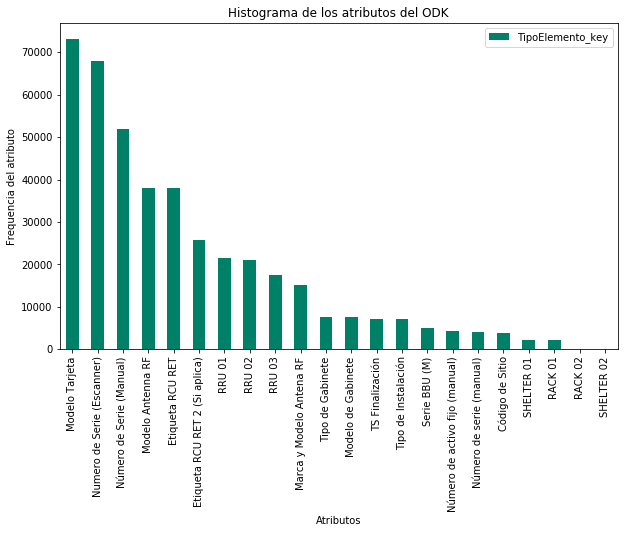

In [8]:
Freq_Atributos.plot(kind='bar',figsize=(10,6),rot=90,colormap='summer')

plt.title('Histograma de los atributos del ODK')
plt.ylabel('Frequencia del atributo')
plt.xlabel('Atributos')

#### Se hará una limpieza para homologar los campos de serie y activo:

In [9]:
stoppers=[u'numero de',u'escaner',u'manual', u'bbu m', u'escanner', u'fijo']
df['TipoElemento_Key_Clean']=df.TipoElemento_key

df.TipoElemento_Key_Clean=df.TipoElemento_Key_Clean.str.lower()
df.TipoElemento_Key_Clean=df.TipoElemento_Key_Clean.str.replace("\)",'')
df.TipoElemento_Key_Clean=df.TipoElemento_Key_Clean.str.replace("\(",'')
df.TipoElemento_Key_Clean.replace(u'á',u'a',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(u'é',u'e',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(u'í',u'i',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(u'ó',u'o',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(u'ú',u'u',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(u'0',u'',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(u'1',u'',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(u'2',u'',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(u'3',u'',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(u'4',u'',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(u'5',u'',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(u'6',u'',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(u'7',u'',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(u'8',u'',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(u'9',u'',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(stoppers,u'',regex=True,inplace=True)
df.TipoElemento_Key_Clean=df.TipoElemento_Key_Clean.str.strip()

#### Después de haber pasado una limpieza, podemos tener homologados los campos:

In [10]:
#Se debe observar que serie y activo han quedado homologados
pd.DataFrame(df.TipoElemento_Key_Clean.value_counts())

,TipoElemento_Key_Clean
serie,129044
modelo tarjeta,73238
rru,60200
modelo antenna rf,37916
etiqueta rcu ret,37910
etiqueta rcu ret si aplica,25757
marca y modelo antena rf,15034
modelo de gabinete,7610
tipo de gabinete,7610
ts finalizacion,7218


In [11]:
pd.DataFrame(df.TipoElemento_Key_Clean.loc[df.TipoElemento_Key_Clean=='serie'].describe())

,TipoElemento_Key_Clean
count,129044
unique,1
top,serie
freq,129044


In [12]:
pd.DataFrame(df.TipoElemento_Key_Clean.loc[df.TipoElemento_Key_Clean=='activo'].describe())

,TipoElemento_Key_Clean
count,4176
unique,1
top,activo
freq,4176


#### Campo *Modelo Tarjeta*

In [13]:
Cat_ModeloTarjeta=pd.DataFrame(df.TipoElemento_value.loc[df.TipoElemento_Key_Clean=='modelo tarjeta']).drop_duplicates().reset_index(drop=True)
Cat_ModeloTarjeta

,TipoElemento_value
0,UBBPd6
1,WD22UMPTb1
2,WD2MUPEUC
3,OTH
4,FANd
5,QWL1WBBPD2
6,QWL3WBBPF3
7,GTMUb
8,WD2E1FANC
9,QWL1WBBPB2


Podemos encontrar un campo no homologado. Se hará un esfuerzo para limpiar el campo y crear un catálogo.

In [14]:
dirt=['no visible','n/v','nv','ilegible','n/a','na','no legible',
      'n/v deteriorado','sin activo fijo','no vicible','no hay','no tiene','No visble','no visble',
      'No viaible']

Cat_ModeloTarjeta.TipoElemento_value=Cat_ModeloTarjeta.TipoElemento_value.str.upper()
#Cat_ModeloTarjeta.TipoElemento_value=Cat_ModeloTarjeta.TipoElemento_value.str.replace('.',inplace=True)
Cat_ModeloTarjeta.replace(u'inc.','',regex=True,inplace=True)
Cat_ModeloTarjeta.replace(u'inc.','',regex=True,inplace=True)
Cat_ModeloTarjeta.replace(dirt,'',regex=True,inplace=True)
Cat_ModeloTarjeta.dropna(inplace=True)
Cat_ModeloTarjeta.rename(columns={'TipoElemento_value': 'Atributos'}, inplace=True)

#### Campo *Modelo Antena RF*

In [15]:
Cat_ModeloAntenaRF=pd.DataFrame(df.TipoElemento_value.loc[df.TipoElemento_Key_Clean=='modelo antenna rf']).drop_duplicates().reset_index(drop=True)
Cat_ModeloAntenaRF

,TipoElemento_value
0,HBXX-6516DS-A2M
1,ODV-065R17E18K-G
2,ADU4518R1V01
3,80010765V01
4,ADU4518R0
5,ODV2-065R18K-G-V1
6,ODI2-065R18K-GQ
7,OTH
8,DBXLH-6565EC-A2M
9,80010622V01


Podemos encontrar un campo no homologado. Se hará un esfuerzo para limpiar el campo y crear un catálogo.

In [16]:
dirt=['no visible','n/v','nv','ilegible','n/a','na','no legible',
      'n/v deteriorado','sin activo fijo','no vicible','no hay','no tiene','No visble','no visble',
      'No viaible']

Cat_ModeloAntenaRF.TipoElemento_value=Cat_ModeloAntenaRF.TipoElemento_value.str.upper()
Cat_ModeloAntenaRF.replace(u'inc.','',regex=True,inplace=True)
Cat_ModeloAntenaRF.replace(u'inc.','',regex=True,inplace=True)
Cat_ModeloAntenaRF.replace(dirt,'',regex=True,inplace=True)
Cat_ModeloAntenaRF.dropna(inplace=True)
Cat_ModeloAntenaRF.rename(columns={'TipoElemento_value': 'Atributos'}, inplace=True)

#### Hacemos más limpieza para poder eliminar basura.
Esta limpieza se sigue tomando del catálogo que se encuentra en Hive *regex_cat_cleanup* y adicional, se aregan a la lista campos que salieron de acuerdo al análisis.

In [17]:
dirt=['no visible','n/v','nv','ilegible','n/a', 's/a', 'na','no legible',
      'n/v deteriorado','sin activo fijo','no vicible','no hay','no tiene','no visble','no visble',
      'no viaible', '.fhy', 'bxfj', 'cambiar la foto', 'hdjdjjdjfjfj', 'hdjrnnfjfjf', 'hffhthjih', 'hhyhigch',
      'hswkwjj', 'no aplica', 'no pude borrar elemnto', 'ns no visible', 'sin serie', 'sitio ibs no aplica', 'tutj',
      'uflp serie no visible', 'xxxxxxx', 'hsid# djdncg', 'sin información disponible', 'no tiene número de serie',
      'hdkoe kg udkke' 'no se ve', 'ninguna', 'no tiene etiqueta y no se alcnaza a ver.', 'fue un error',
      'no legible', 'sin etiqueta', 'no disponible', 'no tiene', 'sin datos', 'num de serie no legible', 'etiqueta no legible', 'no cuenta con número de serie',
      'no aplica por error se selecciona una tarjeta más', 'enviado ya en reporte anterior', 'hlk', 'ninguno', 'la antena no tiene etiqueta por lo tanto tampoco número de serie', 'no leguible',
      'sin targeta (por equivocacion se agrego este eslot 18 )', 'no cuenta con numeros de serie', 'enviados en reporte anterior .', 'sin etiqueta de numero de serie',
      'sin numero', 'sin informacion disponible', 'sin acceso a la antena', 'no tiene serie', 'sin acceso', 'no se pudo sacar ya que esta clausurado el sitio',
      'no se hizo por que no tenemos tarjeta se las llevo el ing de huawei gabriel lopez', 'sin informacion disponible', 'no aplica ta este segmento',
      'sin numero de serie visible', 'enviada en reporte  anterior', 'no hay antena', 'no se pudo sacar ya que esta clausurado y nos sacaron de sitio',
      'sin serie falta etiqueta', 'sin numero de serie no cuenta con la etiqueta', 'no tiene etiqueta', 'no existe', 'no serie visible', 'no hay bbu esta en resguardo por el ing gabriel lopez',
      'no legible', 'na', 'na hay  tarjeta', 'sin acceso al numero de serie', 'no visibles', 'uelp serie no visible', 'sin informacion disponible', 'sin tarjeta', 'fue un error de dedo no ay mas slot',
      'codigo no visible', 'num de serie no visible', 'sin informacion', 'no se aprecia el codigo', 'sin numero de serie', 'no trae la etiketa de numero de serie',
      'no aplica.', 'no se pudo sacar el numero  de serie ya q nos sacaron del sitio ya q esta clausurado', 'no tiene serie visible', 'no tiene serial ala vista',
      'no se tiene acceso a la antena', 'etiqueta no visible', 'no se puede tomar la foto porque tenemos la fan', 'n/a  no se instalan antenas', 'no aplica sitio ibs',
      'sin numero', 'no visible', 'kcuvicuv', 'error no hay mas', 'no se puede apreciar el codigo', 'no aplica es ibs.', 'no  cuenta con etiquetas de n/s', 'esta ultima no vale',
      'no hay tarjeta', 'esta no vale', 'falta']

In [18]:
df.TipoElemento_value=df.TipoElemento_value.str.lower()
df.TipoElemento_value=df.TipoElemento_value.str.strip()
df.TipoElemento_value.replace(dirt,np.NaN,regex=True,inplace=True)

In [19]:
df['Trazabilidad']='No Trazable'

In [20]:
df['Trazabilidad'].loc[((df.TipoElemento_Key_Clean=='serie') | (df.TipoElemento_Key_Clean=='activo')) & (df.TipoElemento_value is not np.NaN)]='Trazable'

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [21]:
df.head(10)

,id_form,clave_form,element_group,element,exist,TipoElemento_key,TipoElemento_value,TipoElemento_Key_Clean,Trazabilidad
0,100079,AIATP,groupBbus-1,groupCards-1,True,Numero de Serie (Escanner),022hem4mg6000531,serie,Trazable
1,101025,AIATP,groupBbus-1,groupBbus-1,True,Numero de Serie (Escanner),2102310wygn0g7014852,serie,Trazable
2,101350,AIATP,groupBbus-1,groupCards-1,True,Numero de Serie (Escanner),022hem9wga110408,serie,Trazable
3,101491,AIATP,groupBbus-0,groupCards-4,True,Numero de Serie (Escanner),21023198974md9029272,serie,Trazable
4,102228,AIATP,groupBbus-0,groupCards-3,True,Numero de Serie (Escanner),022hem4mf8018167,serie,Trazable
5,102565,AIATP,groupBbus-1,groupCards-1,True,Numero de Serie (Escanner),022hem6tfb603528,serie,Trazable
6,105936,AIATP,groupBbus-1,groupCards-2,True,Numero de Serie (Escanner),022hem4mg4013730,serie,Trazable
7,106335,AIATP,groupBbus-0,groupCards-0,True,Numero de Serie (Escanner),2102311chkn0g2014076,serie,Trazable
8,107818,AIATP,groupBbus-0,groupCards-1,True,Numero de Serie (Escanner),022hem10h8009411,serie,Trazable
9,107833,AIATP,groupBbus-0,groupCards-1,True,Numero de Serie (Escanner),022hem4mg6002133,serie,Trazable


### 4. Calidad de los datos.
En el parseo de nuestra fuente de ODK se creo el campo de *exist* que corresponde a la limpieza de los atributos que se encuentran en el formulario, con esto eliminando missing values.

### 5. Catálogos.
Se enlistan los catálogos que surgieron de la exploración. 

#### Catálogo Modelo de Tarjeta

In [22]:
Cat_ModeloTarjeta

,Atributos
0,UBBPD6
1,WD22UMPTB1
2,WD2MUPEUC
3,OTH
4,FAND
5,QWL1WBBPD2
6,QWL3WBBPF3
7,GTMUB
8,WD2E1FANC
9,QWL1WBBPB2


#### Catálogo Modelo de Antena RF

In [23]:
Cat_ModeloAntenaRF

,Atributos
0,HBXX-6516DS-A2M
1,ODV-065R17E18K-G
2,ADU4518R1V01
3,80010765V01
4,ADU4518R0
5,ODV2-065R18K-G-V1
6,ODI2-065R18K-GQ
7,OTH
8,DBXLH-6565EC-A2M
9,80010622V01


### 6. Preparación de los datos.
Para la preparación de los datos se propondrán en el modelo lógico para hacer sentido a la información de la fuente. 

#### Reglas utilizadas:
* Se eliminan todos los registros: ('no visible','n/v','nv','ilegible','n/a','na','no legible',
    'n/v deteriorado','sin activo fijo','no vicible','no hay','no tiene',  
    'No visble','no visble','No viaible', etc...).      
* Se pasa lower case todos los atributos (La columna **TipoElemento_value**).
* Se eliminan espacios sobrantes.
* Se eliminan los strings 'NA'.
* Se eliminan las palabras: 'numero de', 'escaner', 'manual' en la columna **TipoElemento_key**.
* Se pasa lower case todos los campos key (La columna **TipoElemento_key**).
* Se eliminan acentos y caracteres '/\'

### 7. Métricas KPI.
Se mostrarán los KPIs generados. 

In [24]:
df.fillna('vacio',inplace=True)

*Aqui se hace el filtro por id_form para hacer ejercicios muestra*

In [25]:
aux=df.copy()

Se documenta el query donde se hace el chequeo con la tabla *parsed_odk* del odk correspondiente:  

``SELECT COUNT(*) FROM inventario.parsed_odk_ WHERE id_form=='37605';
``

Para asegurarnos que estamos tomando los campos correctos y no duplicar información, se eliminaran los registros que contengan dentro del campo **TipoElemento_Key**: 'modelo antena rf', 'ts finalizacion', 'modelo tarjeta' y 'tipo de instalacion'.

In [26]:
#aux=df.loc[df.id_form=='178917']

In [27]:
aux = aux.loc[(aux.TipoElemento_Key_Clean=='serie') | (aux.TipoElemento_Key_Clean=='activo') | (aux.TipoElemento_Key_Clean=='etiqueta rcu ret')  | (aux.TipoElemento_Key_Clean=='etiqueta rcu ret si aplica') | (aux.TipoElemento_Key_Clean=='shelter') | (aux.TipoElemento_Key_Clean=='rack')]

#### Total de elementos

In [28]:
Total_Elementos=aux.loc[(aux.TipoElemento_Key_Clean!=u'activo')].shape[0]
Total_Elementos

171228

In [29]:
aux.loc[(aux.TipoElemento_Key_Clean!=u'activo')]

,id_form,clave_form,element_group,element,exist,TipoElemento_key,TipoElemento_value,TipoElemento_Key_Clean,Trazabilidad
0,100079,AIATP,groupBbus-1,groupCards-1,True,Numero de Serie (Escanner),022hem4mg6000531,serie,Trazable
1,101025,AIATP,groupBbus-1,groupBbus-1,True,Numero de Serie (Escanner),2102310wygn0g7014852,serie,Trazable
2,101350,AIATP,groupBbus-1,groupCards-1,True,Numero de Serie (Escanner),022hem9wga110408,serie,Trazable
3,101491,AIATP,groupBbus-0,groupCards-4,True,Numero de Serie (Escanner),21023198974md9029272,serie,Trazable
4,102228,AIATP,groupBbus-0,groupCards-3,True,Numero de Serie (Escanner),022hem4mf8018167,serie,Trazable
5,102565,AIATP,groupBbus-1,groupCards-1,True,Numero de Serie (Escanner),022hem6tfb603528,serie,Trazable
6,105936,AIATP,groupBbus-1,groupCards-2,True,Numero de Serie (Escanner),022hem4mg4013730,serie,Trazable
7,106335,AIATP,groupBbus-0,groupCards-0,True,Numero de Serie (Escanner),2102311chkn0g2014076,serie,Trazable
8,107818,AIATP,groupBbus-0,groupCards-1,True,Numero de Serie (Escanner),022hem10h8009411,serie,Trazable
9,107833,AIATP,groupBbus-0,groupCards-1,True,Numero de Serie (Escanner),022hem4mg6002133,serie,Trazable


#### Total Elementos Trazables

Para el total de elementos trazables haremos una extracción del campo **TipoElemento_Key_Clean**  sea igual a **serie** o **activo**, esto nos servirá para poder hacer el calculado de los indicadores con serie con activo, con serie sin activo, sin serie con activo.  

In [31]:
dfTrazables = pandasql.sqldf("WITH serie as (SELECT id_form, element_group, element, TipoElemento_Key_Clean as serie, tipoelemento_value as valor_serie FROM aux WHERE lower(TipoElemento_Key_Clean) = 'serie'), activo as ( SELECT id_form, element_group, element, TipoElemento_Key_Clean as activo, tipoelemento_value as valor_activo FROM aux WHERE lower(TipoElemento_Key_Clean) = 'activo') SELECT a.id_form, a.element, a.element_group, serie, valor_serie, activo, valor_activo FROM serie a LEFT JOIN activo b ON a.id_form = b.id_form AND a.element = b.element AND a.element_group = b.element_group;", locals())

In [32]:
dfTrazables.activo.replace(to_replace=[None], value='activo', inplace=True)
dfTrazables.valor_activo.replace(to_replace=[None], value=np.nan, inplace=True)
dfTrazables.valor_activo.fillna('vacio',inplace=True)

In [33]:
Total_Tr=dfTrazables.loc[(dfTrazables.valor_serie!='vacio') | (dfTrazables.valor_activo!='vacio')].shape[0]
Total_Tr

127770

#### Total Elementos NO Trazables

In [34]:
Total_NOTr=Total_Elementos-Total_Tr
Total_NOTr

43458

#### Total Elementos Trazables Únicos

In [35]:
Total_Tr_Unic=dfTrazables[['valor_serie','valor_activo']].loc[(dfTrazables.valor_serie!='vacio') | (dfTrazables.valor_activo!='vacio')].drop_duplicates().shape[0]
Total_Tr_Unic

96328

#### Total Elementos Trazables Duplicados

In [36]:
Total_Tr_Dupli=Total_Tr-Total_Tr_Unic
Total_Tr_Dupli

31442

#### Total Elementos Trazables Únicos Con Serie Con Activo

In [37]:
Total_Tr_Unic_CS_CA=dfTrazables[['valor_serie','valor_activo']].loc[(dfTrazables.valor_serie!='vacio') & (dfTrazables.valor_activo!='vacio')].drop_duplicates().shape[0]
Total_Tr_Unic_CS_CA

2561

#### Total Elementos Trazables Únicos Con Serie Sin Activo

In [38]:
Total_Tr_Unic_CS_SA=dfTrazables[['valor_serie','valor_activo']].loc[(dfTrazables.valor_serie!='vacio') & (dfTrazables.valor_activo=='vacio')].drop_duplicates().shape[0]
Total_Tr_Unic_CS_SA

93640

#### Total Elementos Trazables Únicos Sin Serie Con Activo

In [39]:
Total_Tr_Unic_SS_CA=dfTrazables[['valor_serie','valor_activo']].loc[(dfTrazables.valor_serie=='vacio') & (dfTrazables.valor_activo!='vacio')].drop_duplicates().shape[0]
Total_Tr_Unic_SS_CA

127

In [40]:
KPIs=pd.DataFrame({'KPI':['Total Elementos','Total Elementos Trazables',
                         'Total NO Trazables','Total Trazables Unicos',
                         'Total Trazables Duplicados',
                          'Total CS CA','Total CS SA','Total SS CA'],
                  'Resultado':[Total_Elementos,Total_Tr,Total_NOTr,
                              Total_Tr_Unic,Total_Tr_Dupli,
                               Total_Tr_Unic_CS_CA,Total_Tr_Unic_CS_SA,
                              Total_Tr_Unic_SS_CA]})

KPIs

,KPI,Resultado
0,Total Elementos,171228
1,Total Elementos Trazables,127770
2,Total NO Trazables,43458
3,Total Trazables Unicos,96328
4,Total Trazables Duplicados,31442
5,Total CS CA,2561
6,Total CS SA,93640
7,Total SS CA,127


In [46]:
df_hive_kpi = spark.createDataFrame(KPIs)

In [49]:
#Se sube la tabla a Hive
df_hive_kpi.write.mode("overwrite").saveAsTable("default.kpi_odk_32")